# Análise preditiva do Programa Mais Médicos

## 1. Análise preditiva para desfecho categórico (churn)

In [14]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import optuna


### Carregamento dos dados

In [2]:
df = pd.read_csv('C:\\Users\\Lapei_Cigets\\Documents\\GitHub\\sa_maismedicos\\01_dados\\dados resultantes\\df_modelagem.csv')

df = df.drop(["Unnamed: 0",
              "meses_no_local_alocado"], 
             axis='columns')

df[['m_agente_saude', 'm_tec_aux_enf', 'm_enfermeiro', 'm_dentista']] = df[['m_agente_saude', 'm_tec_aux_enf', 'm_enfermeiro', 'm_dentista']].fillna(0)
df['churn'] = df['churn'].map({'permanece': 0, 'migrou': 1})

In [3]:
df.head()

,churn,idade,atuacao_previa_no_municipio,anos_atuacao_previa_no_municipio,media_vinculos_mes,Prorrogado,m_agente_saude,m_tec_aux_enf,m_enfermeiro,m_dentista,...,variacao_pib,tx_pop_ocupada_2019,orcamento_saude,esgotamento_sanitario,taxa_homicidio,ideb_anosfinais,investimento_infraestrutura,equipamentos_esportivos,equipamentos_culturais,distancia_capital
0,0,35,Não,0.0,2.343284,NÃO,9.473684,8.513158,4.815789,0.000000,...,66,11.356216,366.57,0.0,33.946,4.3,103.676,5.703,9.125,636.0
1,1,30,Não,0.0,1.000000,NÃO,13.375000,1.000000,1.625000,1.000000,...,61,15.844714,683.09,0.0,64.522,4.7,5021.768,18.540,4.635,114.0
2,0,75,Não,0.0,1.000000,SIM,9.411765,3.562500,1.889706,1.338235,...,120,8.658503,626.30,0.0,37.161,4.6,3097.942,0.000,4.144,147.0
3,1,37,Não,0.0,1.000000,NÃO,7.771429,1.000000,1.000000,0.000000,...,111,3.407013,457.94,0.0,19.552,5.3,3190.453,2.464,4.928,155.0
4,1,62,Não,0.0,1.000000,SIM,5.328358,2.014925,1.000000,1.000000,...,109,17.059704,614.94,0.0,24.491,4.0,4048.908,12.291,4.097,158.0


### Pré-processamento

In [4]:
y = df['churn']  
X = df.drop(columns=['churn']) 

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()


num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'first'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

X_transformed = preprocessor.fit_transform(X)



## Dividindo em treino e teste

In [5]:
X_train_transformed, X_test_transformed, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, stratify=y, random_state=42)

In [6]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

## Instanciando modelos e rodando modelos

In [7]:
# Modelos
models = {
    'Logistic Regression': LogisticRegression(n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method='hist'),
    'LightGBM': lgb.LGBMClassifier(),
    'Support Vector Classifier': SVC(probability=True)
}

# Hiperparâmetros para GridSearch
param_grids = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10]},
    'Decision Tree': {'max_depth': [3, 5, 10]},
    'Random Forest': {
        'n_estimators': [100, 300, 500],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 300, 500],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.85, 1.0],
        'colsample_bytree': [0.7, 0.85, 1.0],
        'gamma': [0, 0.1, 0.5]
    },
    'LightGBM': {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [20, 31, 40],
        'min_child_samples': [10, 20, 30]
    },
    'Support Vector Classifier': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
}

# Validação cruzada e otimização de hiperparâmetros com Optuna
best_models = {}

def objective(trial, model, X_train_resampled, y_train_resampled):
    param_grid = param_grids.get(model, {})
    trial_params = {k: trial.suggest_categorical(k, v) if isinstance(v, list) else trial.suggest_float(k, v[0], v[1]) for k, v in param_grid.items()}
    clf = models[model].set_params(**trial_params)
    clf.fit(X_train_resampled, y_train_resampled)
    y_prob = clf.predict_proba(X_test_transformed)[:, 1]
    return roc_auc_score(y_test, y_prob)

for name, model in models.items():
    print(f"Otimizando modelo: {name}")
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, name, X_train_resampled, y_train_resampled), n_trials=20)
    best_models[name] = models[name].set_params(**study.best_params)
    print(f"Melhores parâmetros para {name}: {study.best_params}\n")

# Avaliação final no conjunto de teste
results = []
for name, model in best_models.items():
    y_pred = model.predict(X_test_transformed)
    y_prob = model.predict_proba(X_test_transformed)[:, 1]
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob)
    })


[I 2025-02-21 08:03:22,776] A new study created in memory with name: no-name-d3d10648-463c-43a6-a990-4aa80511b5a8


Otimizando modelo: Logistic Regression


[I 2025-02-21 08:03:24,368] Trial 0 finished with value: 0.7891885661595205 and parameters: {'C': 10}. Best is trial 0 with value: 0.7891885661595205.
[I 2025-02-21 08:03:25,208] Trial 1 finished with value: 0.7954126325495621 and parameters: {'C': 0.1}. Best is trial 1 with value: 0.7954126325495621.
[I 2025-02-21 08:03:26,056] Trial 2 finished with value: 0.7954126325495621 and parameters: {'C': 0.1}. Best is trial 1 with value: 0.7954126325495621.
[I 2025-02-21 08:03:26,853] Trial 3 finished with value: 0.7891885661595205 and parameters: {'C': 10}. Best is trial 1 with value: 0.7954126325495621.
[I 2025-02-21 08:03:27,686] Trial 4 finished with value: 0.7895343476256339 and parameters: {'C': 1}. Best is trial 1 with value: 0.7954126325495621.
[I 2025-02-21 08:03:28,482] Trial 5 finished with value: 0.7891885661595205 and parameters: {'C': 10}. Best is trial 1 with value: 0.7954126325495621.
[I 2025-02-21 08:03:29,275] Trial 6 finished with value: 0.7891885661595205 and parameters: {

Melhores parâmetros para Logistic Regression: {'C': 0.01}

Otimizando modelo: Decision Tree


[I 2025-02-21 08:03:30,579] Trial 10 finished with value: 0.7472625633932687 and parameters: {'max_depth': 3}. Best is trial 0 with value: 0.7472625633932687.
[I 2025-02-21 08:03:30,587] Trial 11 finished with value: 0.7472625633932687 and parameters: {'max_depth': 3}. Best is trial 0 with value: 0.7472625633932687.
[I 2025-02-21 08:03:30,603] Trial 12 finished with value: 0.7472625633932687 and parameters: {'max_depth': 3}. Best is trial 0 with value: 0.7472625633932687.
[I 2025-02-21 08:03:30,616] Trial 13 finished with value: 0.7472625633932687 and parameters: {'max_depth': 3}. Best is trial 0 with value: 0.7472625633932687.
[I 2025-02-21 08:03:30,633] Trial 14 finished with value: 0.7472625633932687 and parameters: {'max_depth': 3}. Best is trial 0 with value: 0.7472625633932687.
[I 2025-02-21 08:03:30,653] Trial 15 finished with value: 0.7472625633932687 and parameters: {'max_depth': 3}. Best is trial 0 with value: 0.7472625633932687.
[I 2025-02-21 08:03:30,671] Trial 16 finished 

Melhores parâmetros para Decision Tree: {'max_depth': 3}

Otimizando modelo: Random Forest


[I 2025-02-21 08:03:31,300] Trial 0 finished with value: 0.8178307976025818 and parameters: {'n_estimators': 300, 'max_depth': 5, 'min_samples_split': 5}. Best is trial 0 with value: 0.8178307976025818.
[I 2025-02-21 08:03:32,294] Trial 1 finished with value: 0.8120677731673582 and parameters: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 10}. Best is trial 0 with value: 0.8178307976025818.
[I 2025-02-21 08:03:33,080] Trial 2 finished with value: 0.815179806362379 and parameters: {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 2}. Best is trial 0 with value: 0.8178307976025818.
[I 2025-02-21 08:03:33,293] Trial 3 finished with value: 0.8157561088059013 and parameters: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 10}. Best is trial 0 with value: 0.8178307976025818.
[I 2025-02-21 08:03:33,989] Trial 4 finished with value: 0.8189257722452743 and parameters: {'n_estimators': 300, 'max_depth': 3, 'min_samples_split': 5}. Best is trial 4 with value: 0.8

Melhores parâmetros para Random Forest: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 5}

Otimizando modelo: XGBoost


[I 2025-02-21 08:03:44,207] Trial 0 finished with value: 0.7891885661595206 and parameters: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.01, 'subsample': 0.85, 'colsample_bytree': 1.0, 'gamma': 0}. Best is trial 0 with value: 0.7891885661595206.
c:\Users\Lapei_Cigets\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:03:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-02-21 08:03:44,606] Trial 1 finished with value: 0.8036249423697557 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 1.0, 'colsample_bytree': 0.85, 'gamma': 0.5}. Best is trial 1 with value: 0.8036249423697557.
c:\Users\Lapei_Cigets\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:03:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-auto

Melhores parâmetros para XGBoost: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.01, 'subsample': 0.7, 'colsample_bytree': 0.85, 'gamma': 0.1}

Otimizando modelo: LightGBM
[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5012
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-21 08:03:59,339] Trial 0 finished with value: 0.7755878284923928 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 20, 'min_child_samples': 10}. Best is trial 0 with value: 0.7755878284923928.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5012
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-21 08:03:59,658] Trial 1 finished with value: 0.7635142923005994 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'num_leaves': 40, 'min_child_samples': 10}. Best is trial 0 with value: 0.7755878284923928.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5012
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-21 08:04:00,574] Trial 2 finished with value: 0.7683840479483633 and parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'num_leaves': 40, 'min_child_samples': 30}. Best is trial 0 with value: 0.7755878284923928.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5012
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-21 08:04:01,423] Trial 3 finished with value: 0.7733978792070079 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'num_leaves': 20, 'min_child_samples': 30}. Best is trial 0 with value: 0.7755878284923928.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5012
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-21 08:04:01,800] Trial 4 finished with value: 0.7756454587367452 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'num_leaves': 40, 'min_child_samples': 10}. Best is trial 4 with value: 0.7756454587367452.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5012
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-21 08:04:03,202] Trial 5 finished with value: 0.7733978792070078 and parameters: {'n_estimators': 500, 'learning_rate': 0.01, 'num_leaves': 40, 'min_child_samples': 10}. Best is trial 4 with value: 0.7756454587367452.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5012
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-21 08:04:03,968] Trial 6 finished with value: 0.7759912402028585 and parameters: {'n_estimators': 300, 'learning_rate': 0.01, 'num_leaves': 40, 'min_child_samples': 10}. Best is trial 6 with value: 0.7759912402028585.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5012
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-21 08:04:04,637] Trial 7 finished with value: 0.7702858460119871 and parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'num_leaves': 31, 'min_child_samples': 10}. Best is trial 6 with value: 0.7759912402028585.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5012
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-21 08:04:05,908] Trial 8 finished with value: 0.7709197786998617 and parameters: {'n_estimators': 500, 'learning_rate': 0.01, 'num_leaves': 40, 'min_child_samples': 20}. Best is trial 6 with value: 0.7759912402028585.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5012
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-21 08:04:06,577] Trial 9 finished with value: 0.7878054402950669 and parameters: {'n_estimators': 300, 'learning_rate': 0.01, 'num_leaves': 20, 'min_child_samples': 10}. Best is trial 9 with value: 0.7878054402950669.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5012
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-21 08:04:07,255] Trial 10 finished with value: 0.7844628861226371 and parameters: {'n_estimators': 300, 'learning_rate': 0.01, 'num_leaves': 20, 'min_child_samples': 20}. Best is trial 9 with value: 0.7878054402950669.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5012
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-21 08:04:07,681] Trial 11 finished with value: 0.7844628861226371 and parameters: {'n_estimators': 300, 'learning_rate': 0.01, 'num_leaves': 20, 'min_child_samples': 20}. Best is trial 9 with value: 0.7878054402950669.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5012
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-21 08:04:08,072] Trial 12 finished with value: 0.7844628861226371 and parameters: {'n_estimators': 300, 'learning_rate': 0.01, 'num_leaves': 20, 'min_child_samples': 20}. Best is trial 9 with value: 0.7878054402950669.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5012
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-21 08:04:08,444] Trial 13 finished with value: 0.7844628861226371 and parameters: {'n_estimators': 300, 'learning_rate': 0.01, 'num_leaves': 20, 'min_child_samples': 20}. Best is trial 9 with value: 0.7878054402950669.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5012
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-21 08:04:08,991] Trial 14 finished with value: 0.7821000461041955 and parameters: {'n_estimators': 300, 'learning_rate': 0.01, 'num_leaves': 31, 'min_child_samples': 20}. Best is trial 9 with value: 0.7878054402950669.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5012
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-21 08:04:09,320] Trial 15 finished with value: 0.776106500691563 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'num_leaves': 20, 'min_child_samples': 30}. Best is trial 9 with value: 0.7878054402950669.
[I 2025-02-21 08:04:09,492] Trial 16 finished with value: 0.7794778699861687 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'num_leaves': 20, 'min_child_samples': 20}. Best is trial 9 with value: 0.7878054402950669.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5012
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5012
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-21 08:04:09,991] Trial 17 finished with value: 0.7844628861226371 and parameters: {'n_estimators': 300, 'learning_rate': 0.01, 'num_leaves': 20, 'min_child_samples': 20}. Best is trial 9 with value: 0.7878054402950669.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5012
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-21 08:04:10,679] Trial 18 finished with value: 0.786364684186261 and parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'num_leaves': 31, 'min_child_samples': 10}. Best is trial 9 with value: 0.7878054402950669.


[LightGBM] [Info] Number of positive: 962, number of negative: 962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5012
[LightGBM] [Info] Number of data points in the train set: 1924, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-02-21 08:04:10,927] Trial 19 finished with value: 0.7791032733978791 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'num_leaves': 31, 'min_child_samples': 10}. Best is trial 9 with value: 0.7878054402950669.
[I 2025-02-21 08:04:10,927] A new study created in memory with name: no-name-a56f7592-8288-4ffd-8ce6-674555361c38


Melhores parâmetros para LightGBM: {'n_estimators': 300, 'learning_rate': 0.01, 'num_leaves': 20, 'min_child_samples': 10}

Otimizando modelo: Support Vector Classifier


[I 2025-02-21 08:04:42,085] Trial 0 finished with value: 0.7594513600737668 and parameters: {'C': 10, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.7594513600737668.
[I 2025-02-21 08:04:42,782] Trial 1 finished with value: 0.7256800368833564 and parameters: {'C': 10, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.7594513600737668.
[I 2025-02-21 08:04:43,468] Trial 2 finished with value: 0.7677501152604888 and parameters: {'C': 1, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 2 with value: 0.7677501152604888.
[I 2025-02-21 08:05:21,264] Trial 3 finished with value: 0.7594513600737668 and parameters: {'C': 10, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 2 with value: 0.7677501152604888.
[I 2025-02-21 08:05:21,909] Trial 4 finished with value: 0.7677501152604888 and parameters: {'C': 1, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 2 with value: 0.7677501152604888.
[I 2025-02-21 08:05:23,166] Trial 5 finished with value: 0.7561088059

Melhores parâmetros para Support Vector Classifier: {'C': 0.1, 'kernel': 'rbf', 'gamma': 'auto'}



c:\Users\Lapei_Cigets\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:06:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [8]:
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='ROC AUC', ascending=False))

                       Model  Accuracy  Precision    Recall  F1 Score  \
0        Logistic Regression  0.741214   0.925532  0.721992  0.811189   
2              Random Forest  0.750799   0.879070  0.784232  0.828947   
5  Support Vector Classifier  0.693291   0.914286  0.663900  0.769231   
3                    XGBoost  0.738019   0.829876  0.829876  0.829876   
4                   LightGBM  0.728435   0.842105  0.796680  0.818763   
1              Decision Tree  0.728435   0.861111  0.771784  0.814004   

    ROC AUC  
0  0.809474  
2  0.804979  
5  0.801320  
3  0.780371  
4  0.779103  
1  0.644162  


In [9]:
best_model_name = results_df.sort_values(by='ROC AUC', 
                                         ascending=False).iloc[0]['Model']

best_model = best_models[best_model_name]


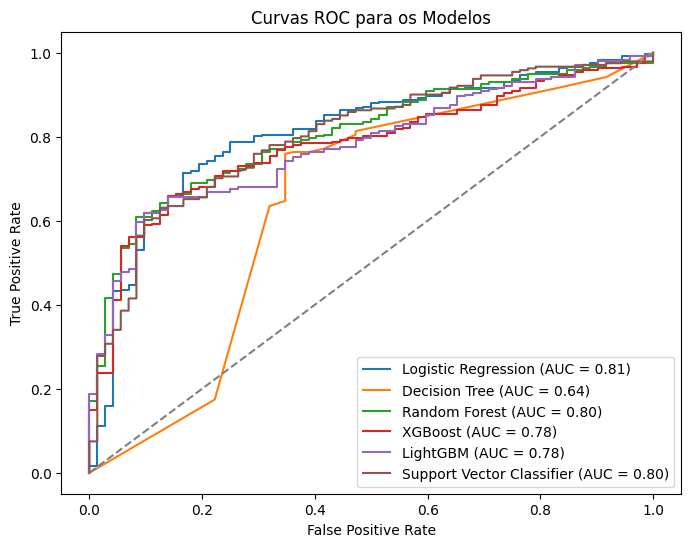

In [10]:
plt.figure(figsize=(8, 6))
for name, model in best_models.items():
    y_prob = model.predict_proba(X_test_transformed)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC para os Modelos')
plt.legend()
plt.show()

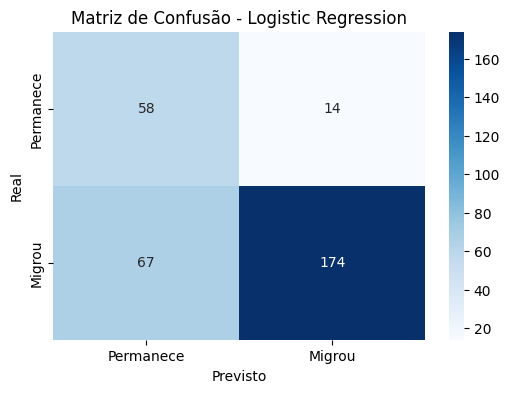

In [11]:
y_pred_best = best_model.predict(X_test_transformed)
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Permanece', 'Migrou'], yticklabels=['Permanece', 'Migrou'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.show()


Melhor limiar: 0.20682495992259575 com F1 Score: 0.8729281767955801


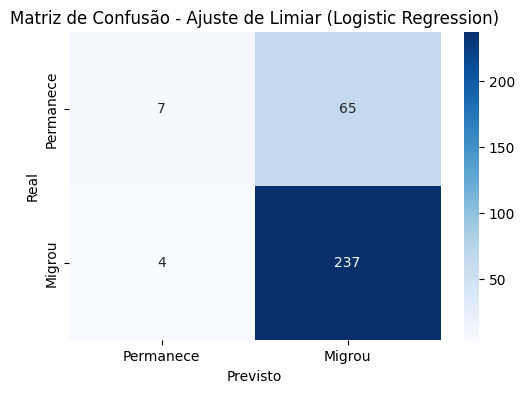

In [15]:
# Ajuste de limiar
y_prob_best = best_model.predict_proba(X_test_transformed)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_best)

# Encontrar o melhor limiar com base no F1 Score
best_threshold = 0.5
best_f1 = 0
for threshold in thresholds:
    y_pred_adjusted = (y_prob_best >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_adjusted)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Melhor limiar: {best_threshold} com F1 Score: {best_f1}")

# Matriz de Confusão com limiar ajustado
y_pred_adjusted = (y_prob_best >= best_threshold).astype(int)
cm_adjusted = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=['Permanece', 'Migrou'], yticklabels=['Permanece', 'Migrou'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão - Ajuste de Limiar ({best_model_name})')
plt.show()

In [16]:
print("ROC AUC: ", roc_auc_score(y_test, y_pred_adjusted))
print("Precision: ", precision_score(y_test, y_pred_adjusted))
print("Accuracy: ", accuracy_score(y_test, y_pred_adjusted))
print("Recall: ", recall_score(y_test, y_pred_adjusted))
print("F1 Score: ", f1_score(y_test, y_pred))
print("Houve perda da área abaixo da curva ROC e no Recall. Nas outras métricas, houve melhora")

ROC AUC:  0.5403123559243891
Precision:  0.7847682119205298
Accuracy:  0.7795527156549521
Recall:  0.983402489626556
F1 Score:  0.7692307692307693
Houve perda da área abaixo da curva ROC e no Recall. Nas outras métricas, houve melhora


In [17]:
if isinstance(best_model, RandomForestClassifier):
    plt.figure(figsize=(20, 10))
    plot_tree(best_model.estimators_[0],  # Pegamos a primeira árvore da floresta
              feature_names=feature_names,
              class_names=['Permanece', 'Migrou'],
              filled=True,
              rounded=True)
    plt.title("Visualização de uma árvore da Random Forest")
    plt.savefig("random_forest_tree.svg", format="svg")
    plt.show()
    
    # Gerar gráfico de importância das features com eixos invertidos
    feature_importances = pd.Series(best_model.feature_importances_, index=feature_names).sort_values()
    plt.figure(figsize=(10, 8))
    feature_importances.plot(kind='barh')
    plt.title("Importância das Features na Random Forest")
    plt.xlabel("Importância")
    plt.ylabel("Feature")
    plt.savefig("random_forest_feature_importance.svg", format="svg")
    plt.show()
else:
    print("O melhor modelo não é uma Random Forest.")

O melhor modelo não é uma Random Forest.


# SHAP

O código abaixo é usado para treinar o modelo com a base completa

In [23]:
# Aplicar a transformação nos dados de entrada
X_transformed = best_model.named_steps['preprocessor'].transform(X)

# Criar o explicador SHAP para a regressão logística usando predict_proba
explainer = shap.Explainer(best_model.named_steps['classifier'].predict_proba, X_transformed)

# Obter os valores SHAP para a classe positiva (índice 1 do predict_proba)
shap_values = explainer(X_transformed)

# Converter X_transformed para DataFrame com os nomes das colunas originais
X_transformed_df = pd.DataFrame(X_transformed, columns=best_model.named_steps['preprocessor'].get_feature_names_out())

# Criar os gráficos de explicabilidade
shap.summary_plot(shap_values[..., 1], X_transformed_df, feature_names=X_transformed_df.columns)
shap.summary_plot(shap_values[..., 1], X_transformed_df, feature_names=X_transformed_df.columns, plot_type="bar")


AttributeError: 'LogisticRegression' object has no attribute 'named_steps'